# Introduction
This is a notebook using machine learning to output the schedule of suppliers.
First import the data in the form of a csv file. The input of the model will be a date and the output will be a list of days corresponding to the schedule of the suppliers and when they will arrive next.

# Imports

In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

# Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset has 2 columns:
* **tanggal** - The date a supplier visited
* **supplier** - The supplier that visited on the day

In [31]:
# filepath = 'data/supplier_dates.csv'#supplier schedule on remote server
filepath = '/content/drive/MyDrive/Documents/uni_work/Bangkit2023/batch1/capstone/repo/ml_modeling/supplier_dates.csv'
df = pd.read_csv(filepath, dtype = {'tanggal':str,'supplier':str})
df.head()

,tanggal,supplier
0,2022-01-06,ABA
1,2022-01-06,ABA
2,2022-01-13,ABA
3,2022-01-20,ABA
4,2022-01-27,ABA



# Data Transformation

# Transform data
We need to change the data so that it has the following format for training:
- **Input:** *The tokenized item code, year, day, month, day of the week, day of the year*
- **Output:** Days until the supplier is set to arrive.
>**Note:**
    - *The tokenized item code is the index of the item code in the tokenizer's word index.*
    - *The day component of the date is the day of the month.*
    - *The month component of the date is the month of the year.*
    - *The day of the week is a number between 0 and 6, where 0 is Monday and 6 is Sunday.*
    - *The day of the year is a number between 1 and 365, where January 1st is 1 and December 31st is 365.*


## Multi-hot encoding
We need to turn the data into long format with *suppliers* as the columns and then multi-hot encode it for the date. \
**1** signifies they came on the day. \
**0** signifies they did not. \

This is needed to extract the time interval between dates later.

In [4]:
#multi_hot encode the suppliers based of the date and if they visited on that date or not
#df['supplier'] = np.array([i[0] for i in supplier_sequence],dtype = np.int64)

multi_hot = pd.get_dummies(df, columns = ['supplier'],prefix = '', prefix_sep = '')
multi_hot = multi_hot.drop_duplicates()
multi_hot = multi_hot.groupby('tanggal').sum()
multi_hot = multi_hot.reset_index()
multi_hot = multi_hot.sort_values('tanggal', ascending= False)
multi_hot.head()

,tanggal,ABA,ABK,ABS,ADR,AI,AJW,ALBACAR,ALFA,ANIS,...,TIARA,TUAH,UB,UMJ,URB,UTJ,VG,WOI,WT,YIP
386,2023-04-01,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
385,2023-03-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384,2023-03-30,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
383,2023-03-29,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
382,2023-03-28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Creating targets and cleaning

For the latest date, we do not know when the supplier will come. \
So we need to set unkown values to -1

In [5]:
#swap values of 0 and 1 in the first row of the dataframe (because the first row is the multihot date for supplier visits)
def process_recent(dataframe):
  """
  Swaps the values of 0 and 1 in the first row of the dataframe
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the swapped values of 0 and 1 in the first row of the dataframe
  """
  for i in range(1, len(dataframe.columns)):
    if dataframe.iloc[0,i] == 0:
      dataframe.iloc[0,i] = -1
    else:
      dataframe.iloc[0,i] = 0
  return dataframe
multi_hot = process_recent(multi_hot)
multi_hot

,tanggal,ABA,ABK,ABS,ADR,AI,AJW,ALBACAR,ALFA,ANIS,...,TIARA,TUAH,UB,UMJ,URB,UTJ,VG,WOI,WT,YIP
386,2023-04-01,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,0,-1,-1,-1,-1,-1,0,0
385,2023-03-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384,2023-03-30,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
383,2023-03-29,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
382,2023-03-28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2022-01-07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2022-01-06,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-01-05,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2022-01-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since we also do not have all the dates in our columns, we need a column to determine the amount of days between columns.

In [6]:
#add previous date column
def next_day(dataframe):
  """
  Adds a column containing the previous date
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the previous date
  """
  dataframe['next_data'] = dataframe['tanggal'].shift(1)
  return dataframe
multi_hot = next_day(multi_hot)
multi_hot

,tanggal,ABA,ABK,ABS,ADR,AI,AJW,ALBACAR,ALFA,ANIS,...,TUAH,UB,UMJ,URB,UTJ,VG,WOI,WT,YIP,next_data
386,2023-04-01,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,0,-1,-1,-1,-1,-1,0,0,None
385,2023-03-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023-04-01
384,2023-03-30,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2023-03-31
383,2023-03-29,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,2023-03-30
382,2023-03-28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2023-03-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2022-01-07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2022-01-08
3,2022-01-06,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2022-01-07
2,2022-01-05,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,2022-01-06
1,2022-01-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2022-01-05


In [7]:
#Get the time difference between the current date and the previous date and convert it to days, keep the first row as 0
def time_diff(dataframe):
  """
  Adds a column containing the time difference between the current date and the previous date and convert it to days, keep the first row as 0
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the time difference between the current date and the previous date and convert it to days, keep the first row as 0
  """
  dataframe['time_diff'] = pd.to_datetime(dataframe['next_data']) - pd.to_datetime(dataframe['tanggal'])
  dataframe['time_diff'] = dataframe['time_diff'].dt.days
  dataframe.iloc[0,dataframe.columns.get_loc('time_diff')] = 0
  return dataframe
multi_hot = time_diff(multi_hot)
multi_hot.pop('next_data')
multi_hot.head()

,tanggal,ABA,ABK,ABS,ADR,AI,AJW,ALBACAR,ALFA,ANIS,...,TUAH,UB,UMJ,URB,UTJ,VG,WOI,WT,YIP,time_diff
386,2023-04-01,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,0,-1,-1,-1,-1,-1,0,0,0.0
385,2023-03-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
384,2023-03-30,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.0
383,2023-03-29,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1.0
382,2023-03-28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0


We then populate the table with our target values.

In [8]:
#update each column
def day_until_visit(dataframe):
  """
  Adds a column containing the days till the next visit
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the since last visit limited to a max of 365
  """
  dataframe = dataframe.copy()
  for i in range(1, len(dataframe.columns)-1):
    for j in range(1, len(dataframe)):
      if dataframe.iloc[j,i] == 0 and dataframe.iloc[j - 1,i] == -1:
        dataframe.iloc[j,i] = -1
      elif dataframe.iloc[j,i] == 0:
        dataframe.iloc[j,i] = dataframe.iloc[j - 1,i] + dataframe.iloc[j,dataframe.columns.get_loc('time_diff')]
      else:
        dataframe.iloc[j,i] = 0
  return dataframe
days_diff = day_until_visit(multi_hot)
days_diff.pop('time_diff')
days_diff.head()

,tanggal,ABA,ABK,ABS,ADR,AI,AJW,ALBACAR,ALFA,ANIS,...,TIARA,TUAH,UB,UMJ,URB,UTJ,VG,WOI,WT,YIP
386,2023-04-01,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,0,-1,-1,-1,-1,-1,0,0
385,2023-03-31,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,1
384,2023-03-30,0,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,2,-1,-1,-1,-1,0,2,2
383,2023-03-29,1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,3,0,-1,-1,0,1,3,3
382,2023-03-28,2,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,4,1,-1,-1,0,2,4,4


We now have the data in the form we want, and the targets that we need for our model. We just have to clean the data so that the unkown targets are removed.

In [9]:
#turn dataframe from wide to long
def wide_to_long(dataframe):
  """
  Turns the dataframe from wide to long
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the dates in long form
  """
  dataframe = dataframe.copy()
  dataframe = dataframe.melt(id_vars = ['tanggal'], var_name = 'supplier', value_name = 'days_to_next_visit')
  return dataframe
long_data = wide_to_long(days_diff)
long_data

,tanggal,supplier,days_to_next_visit
0,2023-04-01,ABA,-1
1,2023-03-31,ABA,-1
2,2023-03-30,ABA,0
3,2023-03-29,ABA,1
4,2023-03-28,ABA,2
...,...,...,...
39469,2022-01-07,YIP,1
39470,2022-01-06,YIP,2
39471,2022-01-05,YIP,3
39472,2022-01-04,YIP,4


Resulting in a clean dataset.

In [10]:
#remove all rows with -1 as the value for days_to_next_visit
def remove_neg(dataframe):
  """
  Removes all rows with -1 as the value for days_to_next_visit
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the dates with no -1 values
  """
  dataframe = dataframe.copy()
  dataframe = dataframe[dataframe['days_to_next_visit'] != -1]
  return dataframe
long_data = remove_neg(long_data)
long_data.head()

,tanggal,supplier,days_to_next_visit
2,2023-03-30,ABA,0
3,2023-03-29,ABA,1
4,2023-03-28,ABA,2
5,2023-03-27,ABA,3
6,2023-03-25,ABA,0


## Extracting the date features and normalization
We now want to extract the date features into it's individual components. \
We also need to turn them into a normalized form so that the training process will reach a global minimum easier.

In [11]:
#add a columns to extract the day of month, month, year, day of week, week of year and day of year
def add_date(dataframe):
  """
  Adds columns to extract the date, month, year, day of week, week of year and day of year
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the dates with the added columns
  """
  dataframe = dataframe.copy()
  dataframe['date'] = pd.to_datetime(dataframe['tanggal'])
  dataframe['year'] = dataframe['date'].dt.year
  dataframe['month'] = dataframe['date'].dt.month
  dataframe['day_of_month'] = dataframe['date'].dt.day
  dataframe['day_of_week'] = dataframe['date'].dt.dayofweek
  dataframe['week_of_year'] = dataframe['date'].dt.isocalendar().week
  dataframe['day_of_year'] = dataframe['date'].dt.dayofyear
  return dataframe
day_features_extracted = add_date(long_data)
day_features_extracted.pop('tanggal')
day_features_extracted.pop('date')
day_features_extracted.head()

,supplier,days_to_next_visit,year,month,day_of_month,day_of_week,week_of_year,day_of_year
2,ABA,0,2023,3,30,3,13,89
3,ABA,1,2023,3,29,2,13,88
4,ABA,2,2023,3,28,1,13,87
5,ABA,3,2023,3,27,0,13,86
6,ABA,0,2023,3,25,5,12,84


We cyclically encode the date features.

In [12]:
#cyclically encode the day, month, day of week, week of year and day of year
day_columns = ['month', 'day_of_month', 'day_of_week', 'week_of_year', 'day_of_year']

cyclic_features = np.array(day_features_extracted[day_columns], dtype=np.float32)
cyclic_features = np.sin(cyclic_features) + np.cos(cyclic_features)

#replace the columns with the cyclically encoded columns
for i, col in enumerate(day_columns):
  day_features_extracted[col] = cyclic_features[:, i]

day_features_extracted['year'] = day_features_extracted['year'].astype(np.float32)
day_features_extracted.head()

,supplier,days_to_next_visit,year,month,day_of_month,day_of_week,week_of_year,day_of_year
2,ABA,0,2023.0,-0.848872,-0.833780,-0.848872,1.327614,1.370246
3,ABA,1,2023.0,-0.848872,-1.411691,0.493151,1.327614,1.034772
4,ABA,2,2023.0,-0.848872,-0.691700,1.381773,1.327614,-0.252068
5,ABA,3,2023.0,-0.848872,0.664237,1.000000,1.327614,-1.307157
6,ABA,0,2023.0,-0.848872,0.858851,-0.675262,0.307281,0.053167


And normalize the targets.

In [13]:
target = day_features_extracted['days_to_next_visit']
target_mean = target.mean()
target_std = target.std()
day_features_extracted['days_to_next_visit'] = (target-target_mean)/target_std

## Creating the dataset for training

We then want to create a dataset that will allow us to train the model. \
Arrange the dataframe so that the target is at the end.

In [14]:
#move the days_to_next_visit column to the end
def move_days_to_next_visit(dataframe):
  """
  Moves the days_to_next_visit column to the end
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the dates with the days_to_next_visit column moved to the end
  """
  dataframe = dataframe.copy()
  dataframe['days_to_next_visit'] = dataframe.pop('days_to_next_visit')
  return dataframe

day_features_extracted = move_days_to_next_visit(day_features_extracted)
day_features_extracted.head()

,supplier,year,month,day_of_month,day_of_week,week_of_year,day_of_year,days_to_next_visit
2,ABA,2023.0,-0.848872,-0.833780,-0.848872,1.327614,1.370246,-0.545650
3,ABA,2023.0,-0.848872,-1.411691,0.493151,1.327614,1.034772,-0.524105
4,ABA,2023.0,-0.848872,-0.691700,1.381773,1.327614,-0.252068,-0.502561
5,ABA,2023.0,-0.848872,0.664237,1.000000,1.327614,-1.307157,-0.481016
6,ABA,2023.0,-0.848872,0.858851,-0.675262,0.307281,0.053167,-0.545650


In [15]:
# turn to dataset
string_feature = day_features_extracted['supplier'].values
numeric_feature = day_features_extracted[['year', 'month', 'day_of_month', 'day_of_week', 'week_of_year', 'day_of_year']].values
target = day_features_extracted['days_to_next_visit'].values
dataset = tf.data.Dataset.from_tensor_slices(((string_feature,numeric_feature),target)).shuffle(len(day_features_extracted))

Since we need to test the model, we split that dataset into train, validation and test sets.

In [16]:
#split the dataset into train and test
BATCH_SIZE = 256
BUFFER = len(day_features_extracted)

train_split = int(BUFFER*0.8)
val_split = int(BUFFER*0.1)

train_dataset = dataset.take(train_split)
test_dataset = dataset.skip(train_split)
val_dataset = test_dataset.skip(val_split)
test_dataset = test_dataset.take(val_split)

train_dataset = train_dataset.shuffle(BUFFER).batch(BATCH_SIZE).prefetch(1)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(1)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(1)

# Model Architecture

## Preprocessing layers

Since we have a string as one of our inputs, we need to convert that to a numeric value. \
We create a StringLookup layer to do that.

In [17]:
#create stringlookup layer
def create_string_lookup_layer(dataframe, column_name):
  """
  Creates a string lookup layer
  Args:
    dataframe (dataframe): dataframe containing the dates
    column_name (string): name of the column to be encoded

  Returns:
    string_lookup (object): an instance of the StringLookup class
  """
  dataframe = dataframe.copy()
  string_lookup = tf.keras.layers.StringLookup(vocabulary=dataframe[column_name].unique())
  return string_lookup

vectorizer = create_string_lookup_layer(day_features_extracted, 'supplier')

Create the model and check the architecture.

In [18]:
#create a model
def create_model(vectorization_layer):
    """
    Creates a model
    Args:
        vectorization_layer (object): an instance of the StringLookup class

    Returns:
        model (object): an instance of the Sequential class
    """
    string_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='item_code')
    numeric_input = tf.keras.Input(shape=(len(numeric_feature[0]),), dtype=tf.float32, name='date_days')

    #create an embedding layer for the string input
    emb = vectorization_layer(string_input)
    emb = tf.keras.layers.Embedding(vectorization_layer.vocabulary_size(), output_dim=6)(emb)
    emb = tf.keras.layers.Flatten()(emb)

    #concatenate the embedding layer with the numeric input
    x = tf.keras.layers.Concatenate()([emb, numeric_input])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    #create the output layer
    output = tf.keras.layers.Dense(1)(x)

    #create the model
    model = tf.keras.Model(inputs=[string_input, numeric_input], outputs=output)

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_code (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 1)            0           ['item_code[0][0]']              
                                                                                                  
 embedding (Embedding)          (None, 1, 6)         618         ['string_lookup[0][0]']          
                                                                                                  
 flatten (Flatten)              (None, 6)            0           ['embedding[0][0]']              
                                                                                              

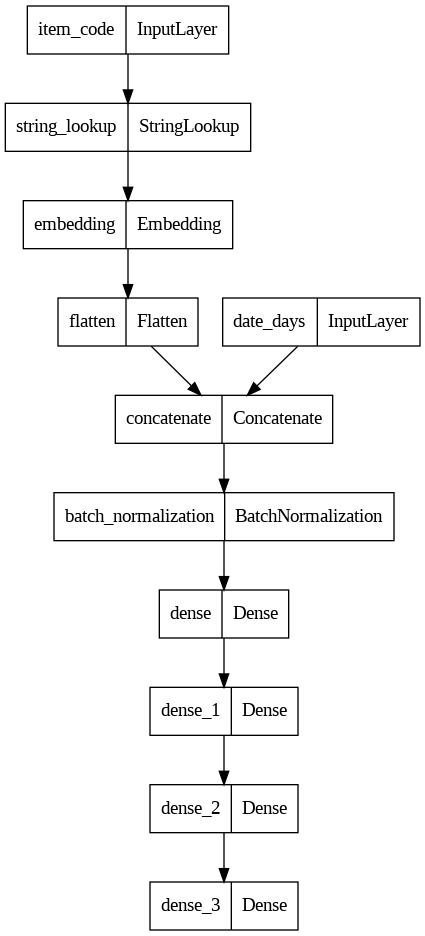

In [19]:
#create a model
model = create_model(vectorizer)
model.summary()
tf.keras.utils.plot_model(model)

## Tuning the learning rate
We use the data and a learning rate scheduler to find the optimal learning rate.

In [20]:
#tune the learning rate
initial_lr = 1e-9
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: initial_lr * 10**(epoch / 20))

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8 * 10,momentum =0.9),
              metrics=['mae', 'mse'])

history = model.fit(train_dataset, epochs=100, callbacks=[lr_schedule],validation_data = val_dataset, verbose=0)


Text(0, 0.5, 'Loss')

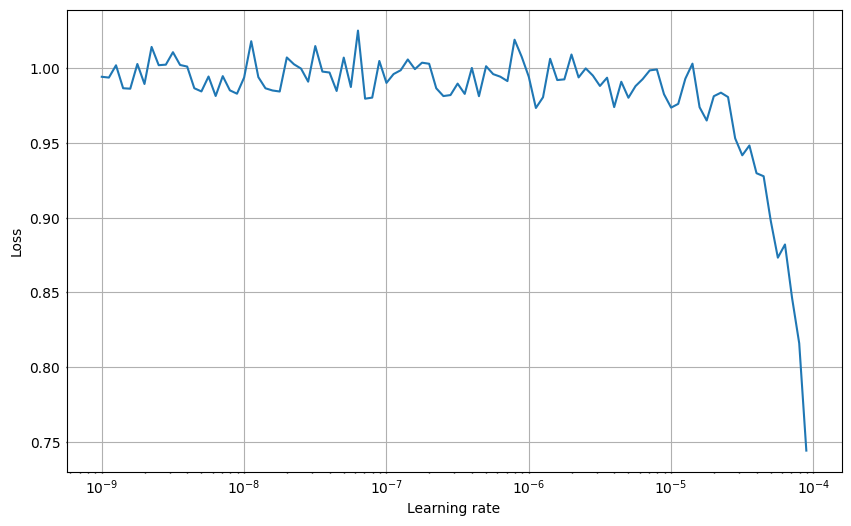

In [21]:
# Define the learning rate array
lrs = initial_lr * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=1, width=1, which='both')
plt.xlabel("Learning rate")
plt.ylabel("Loss")
# plt.ylim(0.5,1.5)

From the graph, whe optimal learning rate is somewhere in the 1e-5 region.
However after some extensive testing this is bad for model performance due to the lack of data. The model underfits extensively. \
We will set the learning rate to be slightly lower, but do a lot more epochs due to the relatively low data amount.

## Model Training

We traing the model using the selected parameters. \
This was done quite a few times due to the loss function diverging.

In [22]:
#set the learning rate
learning_rate = 2e-5

#set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.9)

# set the callback to stop the training if the validation loss doesn't improve
callback = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)

#Reset the states generated by keras
tf.keras.backend.clear_session()

model = create_model(vectorizer)

#compile and train the model
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mae", "mse"])

history = model.fit(train_dataset, epochs=500, validation_data = val_dataset, callbacks=[callback],verbose = 0)

# Analysis

By looking at the graph below, we see that the training loss flattens out while the validation loss is roughly following the training loss.

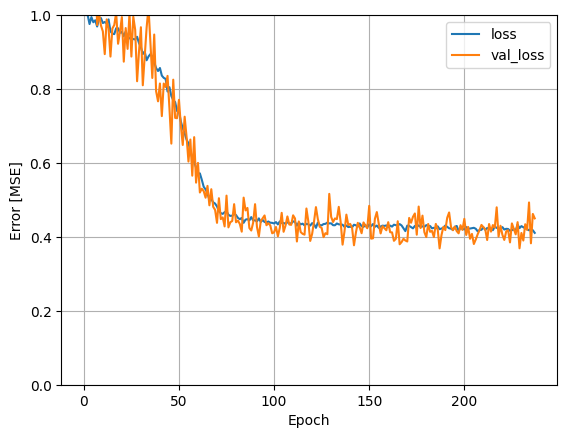

In [35]:
#plot the loss and accuracy for each learning rate
def plot_loss(history):
  """
  Plots the loss and accuracy for each learning rate
  Args:
    history (object): an instance of the History class

  Returns:
    None
  """
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MSE]')
  plt.legend()
  plt.grid(True)
  plt.ylim(0,1)
  plt.show()

plot_loss(history)

In [24]:
test_history = model.evaluate(test_dataset)

13/13 [==============================] - 0s 3ms/step - loss: 0.4171 - mae: 0.3502 - mse: 0.4171


In [29]:
samples = day_features_extracted.sample(20)
string_feature = tf.constant(samples['supplier'].values)
numeric_feature = tf.constant(np.array(samples[['year', 'month', 'day_of_month', 'day_of_week', 'week_of_year', 'day_of_year']],dtype = np.float32))




prediction = model.predict([string_feature,numeric_feature])
prediction = (prediction.flatten()*target_std)+target_mean
prediction = np.int32(prediction)
actual = (samples['days_to_next_visit'].values*target_std)+target_mean
actual = np.int32(actual)


print(list(prediction))
print(list(actual))

1/1 [==============================] - 0s 24ms/step
[34, 9, 5, 8, 169, 7, 100, 20, 17, 14, 0, 53, 57, 4, 25, 6, 3, 21, 95, 23]
[14, 11, 2, 4, 305, 5, 56, 5, 13, 18, 0, 64, 67, 9, 13, 0, 3, 9, 37, 19]


After analyzing the data, we see that there is still room for improvement and the model is slightly overfitting.

In [30]:
model_dir = '/content/drive/MyDrive/Documents/uni_work/Bangkit2023/batch1/capstone/repo/ml_modeling/model'
model.save(os.path.join(model_dir,'supplier'))